# Mount with google drive


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import nesscessary library


In [2]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot as plt
import matplotlib as mpl

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 1. Anomaly Detection


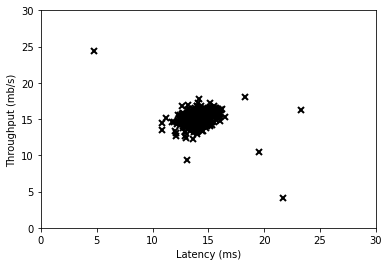

In [3]:
#  The following command loads the dataset.
DATA_ROOT = '/content/gdrive/MyDrive/AIL/Data'
data = loadmat(os.path.join(DATA_ROOT, 'ex8data1.mat'))
X, Xval, yval = data['X'], data['Xval'], data['yval'][:, 0]

#  Visualize the example dataset
plt.plot(X[:, 0], X[:, 1], 'bx', mew=2, mec='k', ms=6)
plt.axis([0, 30, 0, 30])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
pass

### 1.1 Gaussian distribution


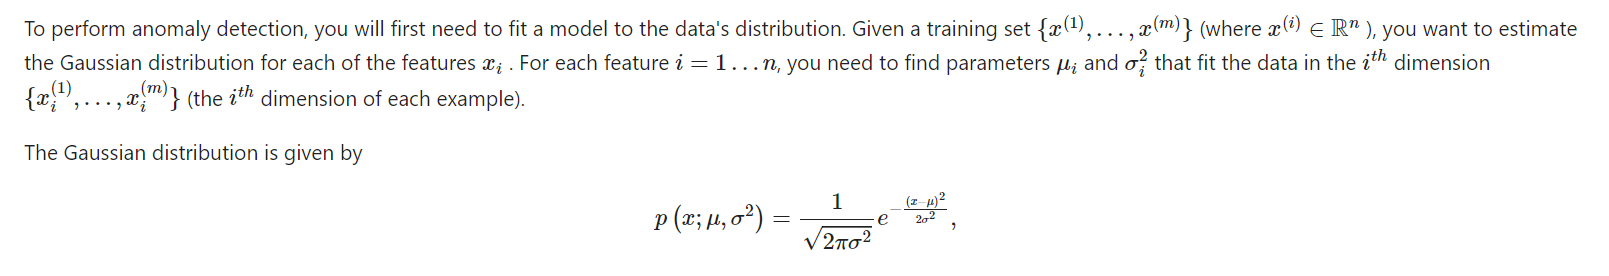

### 1.2 Estimating parameters for a Gaussian

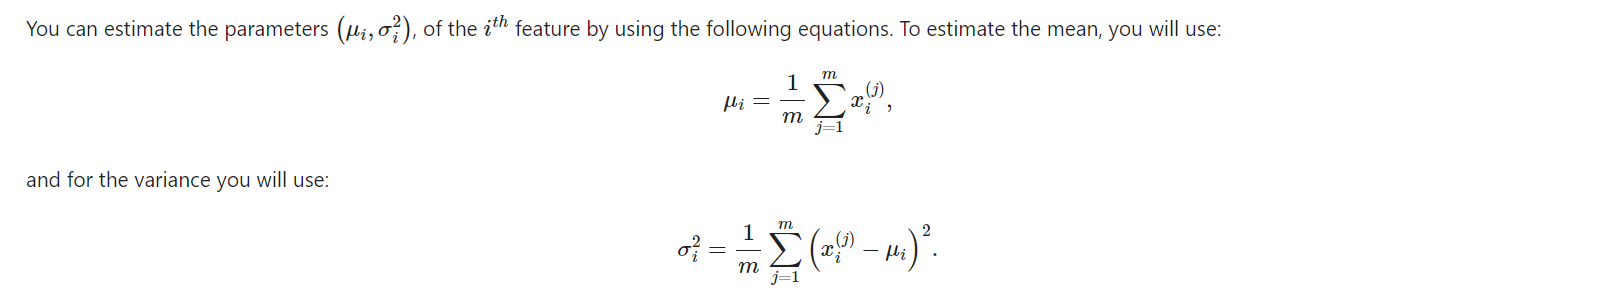

In [4]:
def estimateGaussian(X):
    """
    This function estimates the parameters of a Gaussian distribution
    using a provided dataset.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n) with each n-dimensional 
        data point in one row, and each total of m data points.
    
    Returns
    -------
    mu : array_like 
        A vector of shape (n,) containing the means of each dimension.
    
    sigma2 : array_like
        A vector of shape (n,) containing the computed
        variances of each dimension.
    
    Instructions
    ------------
    Compute the mean of the data and the variances
    In particular, mu[i] should contain the mean of
    the data for the i-th feature and sigma2[i]
    should contain variance of the i-th feature.
    """
    # Useful variables
    m, n = X.shape

    # You should return these values correctly
    mu = np.zeros(n)
    sigma2 = np.zeros(n)

    # ====================== YOUR CODE HERE ======================

    mu = (1 / m) * np.sum(X, axis = 0)
    sigma2 = (1 / m) * np.sum((X - mu) ** 2, axis = 0)
    
    # =============================================================
    return mu, sigma2

In [5]:
def multivariateGaussian(X, mu, Sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n). Where there are m examples of n-dimensions.
    mu : array_like
        A vector of shape (n,) contains the means for each dimension (feature).
    Sigma2 : array_like
        Either a vector of shape (n,) containing the variances of independent features
        (i.e. it is the diagonal of the correlation matrix), or the full
        correlation matrix of shape (n x n) which can represent dependent features.
    Returns
    ------
    p : array_like
        A vector of shape (m,) which contains the computed probabilities at each of the
        provided examples.
    """
    k = mu.size

    # if sigma is given as a diagonal, compute the matrix
    if Sigma2.ndim == 1:
        Sigma2 = np.diag(Sigma2)

    X = X - mu
    p = (2 * np.pi) ** (- k / 2) * np.linalg.det(Sigma2) ** (-0.5)\
        * np.exp(-0.5 * np.sum(np.dot(X, np.linalg.pinv(Sigma2)) * X, axis=1))
    return p


In [6]:
def visualizeFit(X, mu, sigma2):
    """
    Visualize the dataset and its estimated distribution.
    This visualization shows you the  probability density function of the Gaussian distribution.
    Each example has a location (x1, x2) that depends on its feature values.
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x 2). Where there are m examples of 2-dimensions. We need at most
        2-D features to be able to visualize the distribution.
    mu : array_like
        A vector of shape (n,) contains the means for each dimension (feature).
    sigma2 : array_like
        Either a vector of shape (n,) containing the variances of independent features
        (i.e. it is the diagonal of the correlation matrix), or the full
        correlation matrix of shape (n x n) which can represent dependent features.
    """

    X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    Z = multivariateGaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, sigma2)
    Z = Z.reshape(X1.shape)

    plt.plot(X[:, 0], X[:, 1], 'bx', mec='b', mew=2, ms=8)

    if np.all(abs(Z) != np.inf):
        plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), zorder=100)


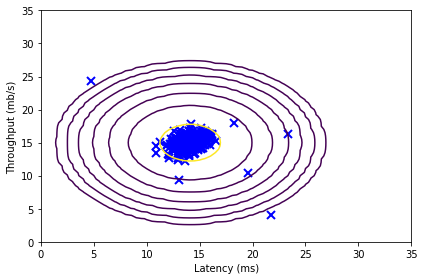

In [7]:
#  Estimate my and sigma2
mu, sigma2 = estimateGaussian(X)

#  Returns the density of the multivariate normal at each data point (row) 
#  of X
p = multivariateGaussian(X, mu, sigma2)

#  Visualize the fit
visualizeFit(X,  mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.tight_layout()

### 1.3 Selecting the threshold

In [8]:
def selectThreshold(yval, pval):
    """
    Find the best threshold (epsilon) to use for selecting outliers based
    on the results from a validation set and the ground truth.
    
    Parameters
    ----------
    yval : array_like
        The validation dataset of shape (m x n) where m is the number 
        of examples an n is the number of dimensions(features).
    
    pval : array_like
        The ground truth labels of shape (m, ).
    
    Returns
    -------
    bestEpsilon : array_like
        A vector of shape (n,) corresponding to the threshold value.
    
    bestF1 : float
        The value for the best F1 score.
    
    Instructions
    ------------
    Compute the F1 score of choosing epsilon as the threshold and place the
    value in F1. The code at the end of the loop will compare the
    F1 score for this choice of epsilon and set it to be the best epsilon if
    it is better than the current choice of epsilon.
    
    Notes
    -----
    You can use predictions = (pval < epsilon) to get a binary vector
    of 0's and 1's of the outlier predictions
    """
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
   
    for epsilon in np.linspace(1.01*min(pval), max(pval), 1000):
        # ====================== YOUR CODE HERE =======================

        predictions = (pval < epsilon)
        tp = np.sum((predictions == yval) & (yval == 1))
        fp = np.sum((predictions == 1) & (yval == 0))
        fn = np.sum((predictions == 0) & (yval == 1))
        
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        
        F1 = 2 * prec * rec / (prec + rec)

        # =============================================================
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1

Best epsilon found using cross-validation: 9.00e-05
Best F1 on Cross Validation Set:  0.875000
   (you should see a value epsilon of about 8.99e-05)
   (you should see a Best F1 value of  0.875000)


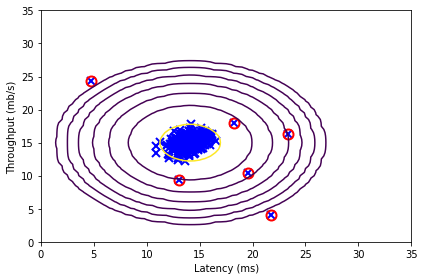

In [9]:
pval = multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation: %.2e' % epsilon)
print('Best F1 on Cross Validation Set:  %f' % F1)
print('   (you should see a value epsilon of about 8.99e-05)')
print('   (you should see a Best F1 value of  0.875000)')

#  Find the outliers in the training set and plot the
outliers = p < epsilon

#  Visualize the fit
visualizeFit(X,  mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.tight_layout()

#  Draw a red circle around those outliers
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', ms=10, mfc='None', mew=2)
pass

### 1.4 High dimensional dataset


In [10]:
#  Loads the second dataset. You should now have the
#  variables X, Xval, yval in your environment
data = loadmat(os.path.join(DATA_ROOT, 'ex8data2.mat'))
X, Xval, yval = data['X'], data['Xval'], data['yval'][:, 0]

# Apply the same steps to the larger dataset
mu, sigma2 = estimateGaussian(X)

#  Training set 
p = multivariateGaussian(X, mu, sigma2)

#  Cross-validation set
pval = multivariateGaussian(Xval, mu, sigma2)

#  Find the best threshold
epsilon, F1 = selectThreshold(yval, pval)

print('Best epsilon found using cross-validation: %.2e' % epsilon)
print('Best F1 on Cross Validation Set          : %f\n' % F1)
print('  (you should see a value epsilon of about 1.38e-18)')
print('   (you should see a Best F1 value of      0.615385)')
print('\n# Outliers found: %d' % np.sum(p < epsilon))

Best epsilon found using cross-validation: 1.38e-18
Best F1 on Cross Validation Set          : 0.615385

  (you should see a value epsilon of about 1.38e-18)
   (you should see a Best F1 value of      0.615385)

# Outliers found: 117


## 2. Recommender Systems


### 2.1 Movie ratings dataset


Average rating for movie 1 (Toy Story): 4.520679 / 5


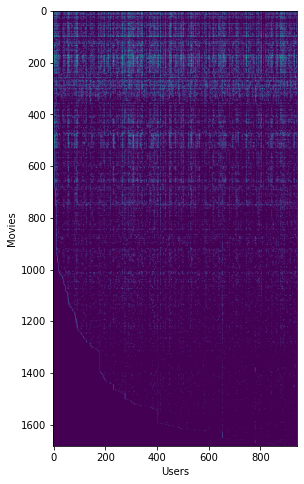

In [11]:
# Load data
data = loadmat(os.path.join(DATA_ROOT, 'ex8_movies.mat'))
Y, R = data['Y'], data['R']

# Y is a 1682x943 matrix, containing ratings (1-5) of 
# 1682 movies on 943 users

# R is a 1682x943 matrix, where R(i,j) = 1 
# if and only if user j gave a rating to movie i

# From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): %f / 5' %
      np.mean(Y[0, R[0, :]]))

# We can "visualize" the ratings matrix by plotting it with imshow
plt.figure(figsize=(8, 8))
plt.imshow(Y)
plt.ylabel('Movies')
plt.xlabel('Users')
plt.grid(False)

## 2.2 Collaborative filtering learning algorithm


2.2.1 Collaborative filtering cost function

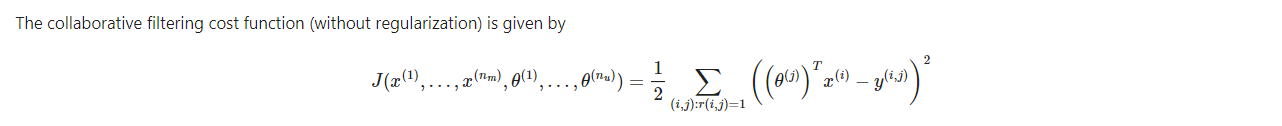

In [12]:
def cofiCostFunc(params, Y, R, num_users, num_movies,
                      num_features, lambda_=0.0):
    """
    Collaborative filtering cost function.
    
    Parameters
    ----------
    params : array_like
        The parameters which will be optimized. This is a one
        dimensional vector of shape (num_movies x num_users, 1). It is the 
        concatenation of the feature vectors X and parameters Theta.
    
    Y : array_like
        A matrix of shape (num_movies x num_users) of user ratings of movies.
    
    R : array_like
        A (num_movies x num_users) matrix, where R[i, j] = 1 if the 
        i-th movie was rated by the j-th user.
    
    num_users : int
        Total number of users.
    
    num_movies : int
        Total number of movies.
    
    num_features : int
        Number of features to learn.
    
    lambda_ : float, optional
        The regularization coefficient.
    
    Returns
    -------
    J : float
        The value of the cost function at the given params.
    
    grad : array_like
        The gradient vector of the cost function at the given params.
        grad has a shape (num_movies x num_users, 1)
    
    Instructions
    ------------
    Compute the cost function and gradient for collaborative filtering.
    Concretely, you should first implement the cost function (without
    regularization) and make sure it is matches our costs. After that,
    you should implement thegradient and use the checkCostFunction routine 
    to check that the gradient is correct. Finally, you should implement
    regularization.
    
    Notes
    -----
    - The input params will be unraveled into the two matrices:
        X : (num_movies  x num_features) matrix of movie features
        Theta : (num_users  x num_features) matrix of user features

    - You should set the following variables correctly:

        X_grad : (num_movies x num_features) matrix, containing the 
                 partial derivatives w.r.t. to each element of X
        Theta_grad : (num_users x num_features) matrix, containing the 
                     partial derivatives w.r.t. to each element of Theta

    - The returned gradient will be the concatenation of the raveled 
      gradients X_grad and Theta_grad.
    """
    # Unfold the U and W matrices from params
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)

    # You need to return the following values correctly
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    # ====================== YOUR CODE HERE ======================

    J = (1 / 2) * np.sum(np.square((X.dot(Theta.T) - Y) * R)) + (lambda_ / 2) * np.sum(np.square(X)) + \
                                                                (lambda_ / 2) * np.sum(np.square(Theta))
    
    for i in range(R.shape[0]):
        
        idx = np.where(R[i, :] == 1)[0]
        Theta_temp = Theta[idx, :]
        Y_temp = Y[i, idx]
        X_grad[i, :] = np.dot(np.dot(X[i, :], Theta_temp.T) - Y_temp, Theta_temp) + lambda_ * X[i, :]
        
    for j in range(R.shape[1]):
        
        idx = np.where(R[:, j] == 1)[0]
        X_temp = X[idx, :]
        Y_temp = Y[idx, j]
        Theta_grad[j, :] = np.dot(np.dot(X_temp, Theta[j, :]) - Y_temp, X_temp) + lambda_ * Theta[j, :]
            
    
    # =============================================================
    
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    return J, grad

In [13]:
#  Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
data = loadmat(os.path.join(DATA_ROOT, 'ex8_movieParams.mat'))
X, Theta, num_users, num_movies, num_features = data['X'],\
        data['Theta'], data['num_users'], data['num_movies'], data['num_features']

#  Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3

X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, 0:num_users]
R = R[:num_movies, 0:num_users]

#  Evaluate cost function
J, _ = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]),
                    Y, R, num_users, num_movies, num_features)
           
print('Cost at loaded parameters:  %.2f \n(this value should be about 22.22)' % J)

Cost at loaded parameters:  22.22 
(this value should be about 22.22)


2.2.2 Collaborative filtering gradient


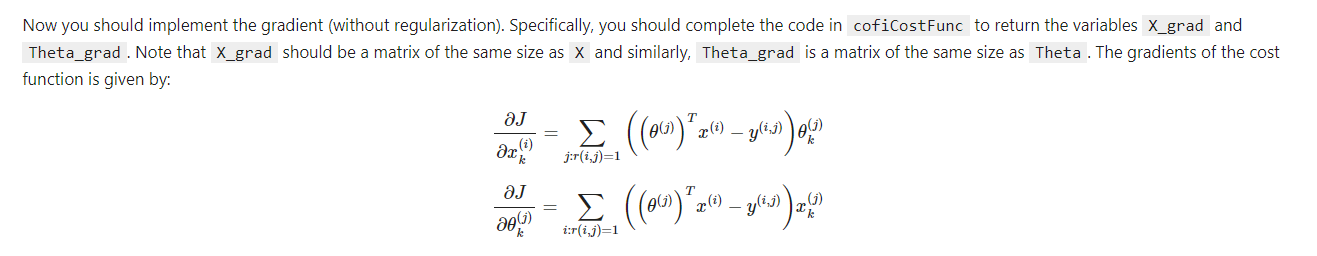

In [15]:
def computeNumericalGradient(J, theta, e=1e-4):
    """
    Computes the gradient using "finite differences" and gives us a numerical estimate of the
    gradient.
    Parameters
    ----------
    J : func
        The cost function which will be used to estimate its numerical gradient.
    theta : array_like
        The one dimensional unrolled network parameters. The numerical gradient is computed at
         those given parameters.
    e : float (optional)
        The value to use for epsilon for computing the finite difference.
    Returns
    -------
    numgrad : array_like
        The numerical gradient with respect to theta. Has same shape as theta.
    Notes
    -----
    The following code implements numerical gradient checking, and
    returns the numerical gradient. It sets `numgrad[i]` to (a numerical
    approximation of) the partial derivative of J with respect to the
    i-th input argument, evaluated at theta. (i.e., `numgrad[i]` should
    be the (approximately) the partial derivative of J with respect
    to theta[i].)
    """
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    for i in range(theta.size):
        loss1, _ = J(theta - perturb[:, i])
        loss2, _ = J(theta + perturb[:, i])
        numgrad[i] = (loss2 - loss1)/(2*e)
    return numgrad


In [16]:
def checkCostFunction(cofiCostFunc, lambda_=0.):
    """
    Creates a collaborative filtering problem to check your cost function and gradients.
    It will output the  analytical gradients produced by your code and the numerical gradients
    (computed using computeNumericalGradient). These two gradient computations should result
    in very similar values.
    Parameters
    ----------
    cofiCostFunc: func
        Implementation of the cost function.
    lambda_ : float, optional
        The regularization parameter.
    """
    # Create small problem
    X_t = np.random.rand(4, 3)
    Theta_t = np.random.rand(5, 3)

    # Zap out most entries
    Y = np.dot(X_t, Theta_t.T)
    Y[np.random.rand(*Y.shape) > 0.5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1

    # Run Gradient Checking
    X = np.random.randn(*X_t.shape)
    Theta = np.random.randn(*Theta_t.shape)
    num_movies, num_users = Y.shape
    num_features = Theta_t.shape[1]

    params = np.concatenate([X.ravel(), Theta.ravel()])
    numgrad = computeNumericalGradient(
        lambda x: cofiCostFunc(x, Y, R, num_users, num_movies, num_features, lambda_), params)

    cost, grad = cofiCostFunc(params, Y, R, num_users,num_movies, num_features, lambda_)

    print(np.stack([numgrad, grad], axis=1))
    print('\nThe above two columns you get should be very similar.'
          '(Left-Your Numerical Gradient, Right-Analytical Gradient)')

    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)
    print('If your cost function implementation is correct, then '
          'the relative difference will be small (less than 1e-9).')
    print('\nRelative Difference: %g' % diff)


In [17]:
checkCostFunction(cofiCostFunc)

[[ 2.96149703  2.96149703]
 [-1.24637672 -1.24637672]
 [-2.01515262 -2.01515262]
 [-0.34935841 -0.34935841]
 [ 0.76638311  0.76638311]
 [ 0.9000651   0.9000651 ]
 [ 1.88275193  1.88275193]
 [-2.43966417 -2.43966417]
 [-2.34007165 -2.34007165]
 [ 4.90541616  4.90541616]
 [ 0.7937821   0.7937821 ]
 [-3.69081203 -3.69081203]
 [ 0.12407164  0.12407164]
 [-0.04515669 -0.04515669]
 [ 0.1079652   0.1079652 ]
 [-3.3803914  -3.3803914 ]
 [ 1.35251907  1.35251907]
 [ 1.19149279  1.19149279]
 [-4.47967143 -4.47967143]
 [ 3.44613406  3.44613406]
 [-3.462583   -3.462583  ]
 [-3.27376205 -3.27376205]
 [ 1.0948698   1.0948698 ]
 [ 0.95049671  0.95049671]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]

The above two columns you get should be very similar.(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your cost function implementation is correct, then the relative difference will be small (less than 1e-9).

Relative Difference: 1.28668e-12


2.2.3 Regularized cost function

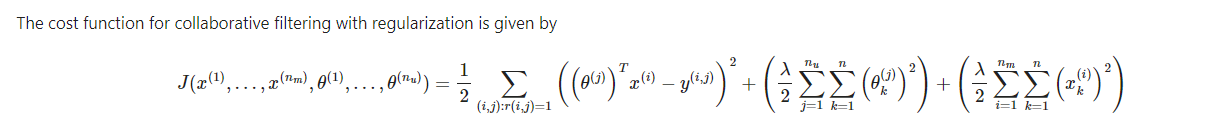

In [18]:
#  Evaluate cost function
J, _ = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]),
                    Y, R, num_users, num_movies, num_features, 1.5)
           
print('Cost at loaded parameters (lambda = 1.5): %.2f' % J)
print('              (this value should be about 31.34)')

Cost at loaded parameters (lambda = 1.5): 31.34
              (this value should be about 31.34)


2.2.4 Regularized gradient


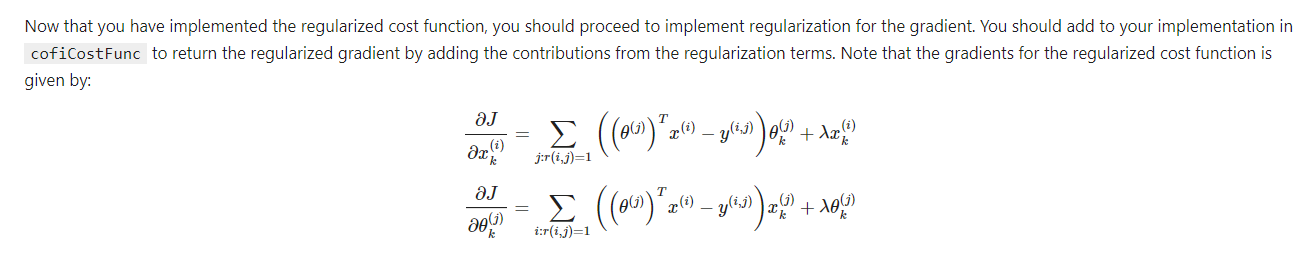

In [19]:
checkCostFunction(cofiCostFunc, 1.5)

[[  6.21714475   6.21714475]
 [  7.90362263   7.90362263]
 [  1.88745284   1.88745284]
 [  8.04714799   8.04714799]
 [-10.9941344  -10.9941344 ]
 [  1.61264169   1.61264169]
 [ -0.85251031  -0.85251031]
 [ -8.68311285  -8.68311285]
 [ -1.97864207  -1.97864207]
 [  0.02762804   0.02762804]
 [ -0.03004368  -0.03004368]
 [  1.0713596    1.0713596 ]
 [ -5.36386266  -5.36386266]
 [ -5.99025972  -5.99025972]
 [ -1.08467856  -1.08467856]
 [  0.83400443   0.83400443]
 [ -5.07414232  -5.07414232]
 [  3.32794243   3.32794243]
 [ -7.02874152  -7.02874152]
 [ 11.41984902  11.41984902]
 [ -4.38076209  -4.38076209]
 [  0.18465279   0.18465279]
 [ -2.03900583  -2.03900583]
 [ -0.08957753  -0.08957753]
 [  1.740983     1.740983  ]
 [  1.40121076   1.40121076]
 [  0.7594815    0.7594815 ]]

The above two columns you get should be very similar.(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your cost function implementation is correct, then the relative difference will be small (less than 1

### 2.3 Learning movie recommendations


In [21]:
def loadMovieList():
    """
    Reads the fixed movie list in movie_ids.txt and returns a list of movie names.
    Returns
    -------
    movieNames : list
        A list of strings, representing all movie names.
    """
    # Read the fixed movieulary list
    with open(join(DATA_ROOT, 'movie_ids.txt'),  encoding='ISO-8859-1') as fid:
        movies = fid.readlines()

    movieNames = []
    for movie in movies:
        parts = movie.split()
        movieNames.append(' '.join(parts[1:]).strip())
    return movieNames


In [25]:
from os.path import join

In [27]:
#  add ratings that correspond to a new user that we just observed. This
#  part of the code will also allow you to put in your own ratings for the
#  movies in our dataset!
movieList = loadMovieList()
n_m = len(movieList)

#  Initialize my ratings
my_ratings = np.zeros(n_m)

# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
# Note that the index here is ID-1, since we start index from 0.
my_ratings[0] = 4

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('New user ratings:')
print('-----------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d stars: %s' % (my_ratings[i], movieList[i]))

New user ratings:
-----------------
Rated 4 stars: Toy Story (1995)
Rated 3 stars: Twelve Monkeys (1995)
Rated 5 stars: Usual Suspects, The (1995)
Rated 4 stars: Outbreak (1995)
Rated 5 stars: Shawshank Redemption, The (1994)
Rated 3 stars: While You Were Sleeping (1995)
Rated 5 stars: Forrest Gump (1994)
Rated 2 stars: Silence of the Lambs, The (1991)
Rated 4 stars: Alien (1979)
Rated 5 stars: Die Hard 2 (1990)
Rated 5 stars: Sphere (1998)


2.3.1 Recommendations


In [ ]:
#  Now, you will train the collaborative filtering model on a movie rating 
#  dataset of 1682 movies and 943 users

#  Load data
data = loadmat(os.path.join(DATA_ROOT, 'ex8_movies.mat'))
Y, R = data['Y'], data['R']

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 
#  943 users

#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  Add our own ratings to the data matrix
Y = np.hstack([my_ratings[:, None], Y])
R = np.hstack([(my_ratings > 0)[:, None], R])

#  Normalize Ratings
Ynorm, Ymean = utils.normalizeRatings(Y, R)

#  Useful Values
num_movies, num_users = Y.shape
num_features = 10

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

# Set options for scipy.optimize.minimize
options = {'maxiter': 100}

# Set Regularization
lambda_ = 10
res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                               num_movies, num_features, lambda_),
                        initial_parameters,
                        method='TNC',
                        jac=True,
                        options=options)
theta = res.x

# Unfold the returned theta back into U and W
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

print('Recommender system learning completed.')

In [ ]:
p = np.dot(X, Theta.T)
my_predictions = p[:, 0] + Ymean

movieList = loadMovieList()

ix = np.argsort(my_predictions)[::-1]

print('Top recommendations for you:')
print('----------------------------')
for i in range(10):
    j = ix[i]
    print('Predicting rating %.1f for movie %s' % (my_predictions[j], movieList[j]))

print('\nOriginal ratings provided:')
print('--------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' % (my_ratings[i], movieList[i]))